In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yfin
plt.style.use('seaborn')

In [3]:
option_prices = pd.read_csv("Historical_Data(1).csv", index_col = 0)
option_prices.index = pd.to_datetime(option_prices.index, format = '%d/%m/%Y')

In [4]:
ENTITLEMENT_RATIO = option_prices['Ent. Ratio^'][0]
STRIKE = option_prices['Strike'][0]

In [5]:
options = option_prices[['Delta (%)', 'Closing Price']]
options.sort_index(axis=0, inplace=True)

In [6]:
asset_prices = yfin.download('0700.HK', start_date = options.index[0].date(), end_date = options.index[-1].date())

asset_prices = asset_prices.loc[options.index[0]:, 'Close']

[*********************100%***********************]  1 of 1 completed


In [7]:
data = pd.concat([options, asset_prices], axis=1, join='inner')
data.columns = ['Delta', 'Option', 'Asset']
data.Option = data.Option * ENTITLEMENT_RATIO

In [8]:
data

,Delta,Option,Asset
2021-11-01,-0.300,24.077576,469.600006
2021-11-02,-0.318,26.213490,464.000000
2021-11-03,-0.301,23.883402,469.000000
2021-11-04,-0.268,21.262053,480.799988
2021-11-05,-0.305,23.980489,467.399994
...,...,...,...
2022-03-07,NaN,33.980450,388.000000
2022-03-08,NaN,36.407625,383.200012
2022-03-09,NaN,39.320235,384.799988
2022-03-10,NaN,35.436755,385.000000


In [9]:
data.Delta = [-float(x[1:-1]) for x in data.Delta]

TypeError: 'float' object is not subscriptable

In [10]:
data.head(2)

,Delta,Option,Asset
2021-11-01,-0.300,24.077576,469.600006
2021-11-02,-0.318,26.213490,464.000000


In [23]:
def tracking_error(weights: np.array, asset_price, option_price, delta):
    
    # print(f"Asset Price: {asset_price}")
    # print(f"Option Price: {option_price}")
    # print(f"weight0: {weights[0]}, weights[1]: {weights[1]/100}")

    portfolio = weights[0] + (weights[1]/100)*asset_price

    err = 100*abs(portfolio - option_price) + (10*abs(delta - weights[1]/100))
    # print(f"Tracking Error: {err}")

    return err

In [24]:
from scipy.optimize import minimize, LinearConstraint
def optimise(asset_price, option_price, constraints, past_weights, delta):

    objective_function = tracking_error

    initial_guess = np.random.random(size=2)
    
    initial_guess[0] *= 400
    initial_guess[1] *= -100
    # print(f"Initial Guess: {initial_guess}")

    args = (asset_price, option_price, delta)
 
    bounds = [(0, 400), (-100, 0)]
    # print(initial_guess)
    # print("Asset Price: ", asset_price, "Option Price: ", option_price)
    result = minimize(objective_function, x0 = initial_guess ,args = args,
                bounds=bounds, options={'disp': False}, constraints=constraints)

    return result

In [25]:
def self_financing_constraint(weights: np.array, last_known_price: float, previous_weights: np.array):

    past_portfolio_value = previous_weights[0] + previous_weights[1] * last_known_price
    present_portfolio_value = weights[1] + weights[1] * last_known_price
    return present_portfolio_value - past_portfolio_value

In [26]:
data['Risk Free'] = 1
data

,Delta,Option,Asset,Risk Free
2021-11-01,-0.300,24.077576,469.600006,1
2021-11-02,-0.318,26.213490,464.000000,1
2021-11-03,-0.301,23.883402,469.000000,1
2021-11-04,-0.268,21.262053,480.799988,1
2021-11-05,-0.305,23.980489,467.399994,1
...,...,...,...,...
2022-03-07,NaN,33.980450,388.000000,1
2022-03-08,NaN,36.407625,383.200012,1
2022-03-09,NaN,39.320235,384.799988,1
2022-03-10,NaN,35.436755,385.000000,1


In [32]:

def replicate():

    
    init_cash = (data.Option - data.Asset * data.Delta)[0]

    allocations = [{
        'allocation':[init_cash, data.Delta[0]],
        'asset close price': data.Asset[1]
    }]
    dates = [data.index[0]]
    for idx, date in enumerate(data.index[:-10]):

        if idx <= 1: continue

    
        asset_price_last_close = data.Asset.iloc[idx - 1]
        option_price_last_close = data.Option.iloc[idx - 1]
        delta = data.Delta.iloc[idx - 1]

        # print("\n")

        # print(f"Date: {date}, Asset Close(t-1): {asset_price_last_close}, Option Price(t-1): {option_price_last_close}")

        previous_weights = allocations[-1]['allocation']

        # print(f"Previous Allocation: {previous_weights}")

        past_portfolio_value = previous_weights[0] + previous_weights[1] * asset_price_last_close
        # print(f"Past Portfolio Value: {past_portfolio_value}")

        if date.dayofweek in [0, 3]:

            dates.append(date)

            self_financing_constraint = LinearConstraint([1, asset_price_last_close/100],
                                        ub = past_portfolio_value, lb = past_portfolio_value)

            weights = optimise(
                            asset_price = asset_price_last_close,
                            option_price = option_price_last_close,
                            constraints = self_financing_constraint,
                            past_weights = previous_weights,
                            delta = delta
                            )['x']

            allocations.append({'allocation':[weights[0], weights[1]/100],
                                'asset close price': data.Asset.iloc[idx]
                                })
                                
    weights = [x['allocation'] for x in allocations]
    hedged_pf = pd.DataFrame(weights, index = dates, columns = ['Risk Free', 'Asset'])
    
    # , index = data.index[1:], columns = ['Risk Free', 'Asset']).multiply(data[['Risk Free', 'Asset']]).sum(axis=1)

    fig, ax = plt.subplots()
    data.Option[hedged_pf.index].plot(ax=ax)
    hedged_pf.multiply(data[['Risk Free', 'Asset']].loc[hedged_pf.index, :]).sum(axis=1).plot(ax=ax, color = 'r')

    return allocations, hedged_pf

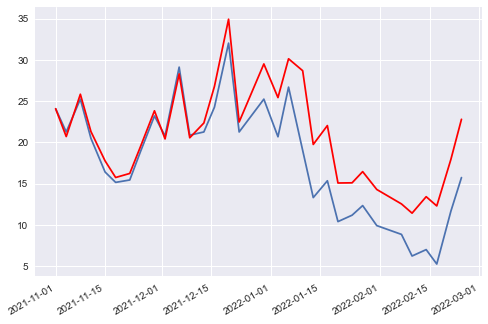

In [37]:
allocations, pf = replicate()

In [31]:
data.Delta.tail(10)

2022-02-28   -0.431
2022-03-01   -0.353
2022-03-02   -0.412
2022-03-03   -0.448
2022-03-04   -0.579
2022-03-07      NaN
2022-03-08      NaN
2022-03-09      NaN
2022-03-10      NaN
2022-03-11      NaN
Name: Delta, dtype: float64

In [202]:
LAST_PRICE = 367.80
DELTA = -0.855
WARRANT_PRICE = 0.5
ENTITLEMENT = 97.087

CASH = WARRANT_PRICE * ENTITLEMENT - DELTA*LAST_PRICE

CASH, DELTA

(363.0125, -0.855)

In [204]:
WARRANT_PRICE * ENTITLEMENT

48.5435

In [203]:
CASH + DELTA*LAST_PRICE

48.543499999999995

In [170]:
allocations[:3]

[{'allocation': [164.95757783105466, -0.3], 'asset close price': 464.0},
 {'allocation': [199.68109569738976, -0.3748351678153773],
  'asset close price': 480.79998779296875},
 {'allocation': [181.64565028453663, -0.33732384112911457],
  'asset close price': 463.79998779296875}]

In [172]:

199.681 - 0.3748*480.799


19.4775348

In [173]:
181.6456 - 0.3373*480.799

19.4720973

In [ ]:
fig, ax = plt.subplots(figsize = (16, 9))

(data.Option.diff() / data.Asset.diff()).rolling(20).mean().plot(ax=ax, color = 'r')
data.Delta.plot()
plt.show()

In [ ]:
period = 2
returns = data.Asset.pct_change(period).dropna()
b = returns[returns > 0].mean()
a = returns[returns < 0].mean()

print(a, b)